In [1]:
import sys
sys.path.append(sys.path[0] + '/deepkexpfam')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from flows import Flow_VI, ObjectDataset
from torch.utils.data import Dataset, DataLoader
from utils import plot_flow2D, plot_object2D

from Datasets import Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring

%matplotlib inline

In [3]:
from torch.distributions.multivariate_normal import MultivariateNormal

# Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring
d = 1
D = 2
layers = 20

batch_size = 100
iterations = 15000
lr = 0.001

names = ['Funnel', 'Banana', 'Ring', 'Uniform', 'Cosine', 'Grid', 'Multiring']
objs = [Funnel(), Banana(), Ring(), Uniform(), Cosine(), Grid(), Multiring()]
flows = []

for i in range(len(names)):
    name = names[i]
    obj = objs[i]
    
    print(name)

    flow = Flow_VI(d, D, layers, coupling_layers='additive')

    optimizer = torch.optim.Adam(flow.cl.parameters(), lr=lr, weight_decay=0)
    dataset = ObjectDataset(obj, batch_size*iterations)
    loader = DataLoader(dataset , batch_size=batch_size , shuffle=True)


    for i, X_train in enumerate(loader):
        flow.sample_params()

        mu_s = flow.cl.mu_s
        sigma_s = flow.cl.sigma_s
        s = flow.cl.s

        dist = MultivariateNormal(mu_s, torch.diag(sigma_s ** 2))
        log_q = dist.log_prob(s)

        dist = MultivariateNormal(torch.ones_like(s), torch.eye(len(s)))
        log_p = dist.log_prob(s)

        for j in range(len(flow.cl.MLP_list)):
            mlp = flow.cl.MLP_list[j]
            for k in range(len(mlp.mu_Ws)):
                mu_W = mlp.mu_Ws[k].view(-1)
                mu_b = mlp.mu_bs[k].view(-1)
                sigma_W = mlp.sigma_Ws[k].view(-1)
                sigma_b = mlp.sigma_bs[k].view(-1)
                W = mlp.Ws[k].view(-1)
                b = mlp.bs[k].view(-1)

                dist = MultivariateNormal(mu_W, torch.diag(sigma_W ** 2))
                log_q = log_q + dist.log_prob(W)

                dist = MultivariateNormal(mu_b, torch.diag(sigma_b ** 2))
                log_q = log_q + dist.log_prob(b)

                dist = MultivariateNormal(torch.zeros_like(W), torch.eye(len(W)))
                log_p = log_p + dist.log_prob(W)

                dist = MultivariateNormal(torch.zeros_like(b), torch.eye(len(b)))
                log_p = log_p + dist.log_prob(b)

        log_like = flow.log_data_likelihood(X_train, with_grad=True)

        cost = log_q - log_p - log_like

        if torch.isnan(log_like) or torch.isinf(log_like):
            print('@@@', i, log_like, log_q)
            continue

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if i % 1000 == 0:
            print(i, log_q - log_p - log_like)
    
    flows.append(flow)

Funnel
0 tensor(15920.9014, grad_fn=<SubBackward0>)
1000 tensor(11320.4658, grad_fn=<SubBackward0>)
2000 tensor(9157.1182, grad_fn=<SubBackward0>)
3000 tensor(7092.7100, grad_fn=<SubBackward0>)
4000 tensor(5409.2402, grad_fn=<SubBackward0>)
5000 tensor(3979.7051, grad_fn=<SubBackward0>)
6000 tensor(2971.5457, grad_fn=<SubBackward0>)
7000 tensor(2075.1975, grad_fn=<SubBackward0>)
8000 tensor(1539.7800, grad_fn=<SubBackward0>)
9000 tensor(1266.7991, grad_fn=<SubBackward0>)
10000 tensor(1098.8881, grad_fn=<SubBackward0>)
11000 tensor(1073.9446, grad_fn=<SubBackward0>)
12000 tensor(1074.5371, grad_fn=<SubBackward0>)
13000 tensor(1164.1379, grad_fn=<SubBackward0>)
14000 tensor(945., grad_fn=<SubBackward0>)
Banana
0 tensor(16269.5488, grad_fn=<SubBackward0>)
1000 tensor(11754.0996, grad_fn=<SubBackward0>)
2000 tensor(9929.6846, grad_fn=<SubBackward0>)
3000 tensor(8212.9961, grad_fn=<SubBackward0>)
4000 tensor(6641.0776, grad_fn=<SubBackward0>)
5000 tensor(5132.3823, grad_fn=<SubBackward0>)
6

In [7]:
from torch.distributions.multivariate_normal import MultivariateNormal

# Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring
d = 1
D = 2
layers = 20

batch_size = 100
iterations = 5000
lr = 0.001
weight_decay = 0.1

obj = Ring()

flow = Flow_VI(d, D, layers, coupling_layers='affine')

optimizer = torch.optim.Adam(flow.cl.parameters(), lr=lr, weight_decay=weight_decay)
dataset = ObjectDataset(obj, batch_size*iterations)
loader = DataLoader(dataset , batch_size=batch_size , shuffle=True)


for i, X_train in enumerate(loader):
    flow.sample_params()
    log_q = 0

    # Lopp through all parameters
    for j in range(len(flow.cl.scales)):
        # in each coupling layer
        scale = flow.cl.scales[j]
        translate = flow.cl.translates[j]

        for mlp in [scale, translate]:
            for k in range(len(scale.mu_Ws)):
                # in each MLP layer
                mu_W = mlp.mu_Ws[k].view(-1)
                mu_b = mlp.mu_bs[k].view(-1)
                sigma_W = mlp.sigma_Ws[k].view(-1)
                sigma_b = mlp.sigma_bs[k].view(-1)
                W = mlp.Ws[k].view(-1)
                b = mlp.bs[k].view(-1)

                dist = MultivariateNormal(mu_W, torch.diag(sigma_W ** 2))
                log_q += dist.log_prob(W)

                dist = MultivariateNormal(mu_b, torch.diag(sigma_b ** 2))
                log_q += dist.log_prob(b)
    
    
    
    log_like = flow.log_data_likelihood(X_train, with_grad=True)
    cost = log_q - log_like
    
    if torch.isnan(log_like) or torch.isinf(log_like):
        print('@@@', i, log_like, log_q)
        continue
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    

    if i % 100 == 0:
        print(i, log_q, log_like, log_q-log_like)

0 tensor(23192.7656, grad_fn=<AddBackward0>) tensor(-997.4954, grad_fn=<SumBackward0>) tensor(24190.2617, grad_fn=<SubBackward0>)


KeyboardInterrupt: 

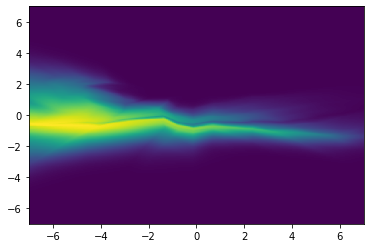

In [14]:
flow.sample_params()
plot_flow2D(flow)

Funnel
Banana
Ring
Uniform
Cosine
Grid
Multiring


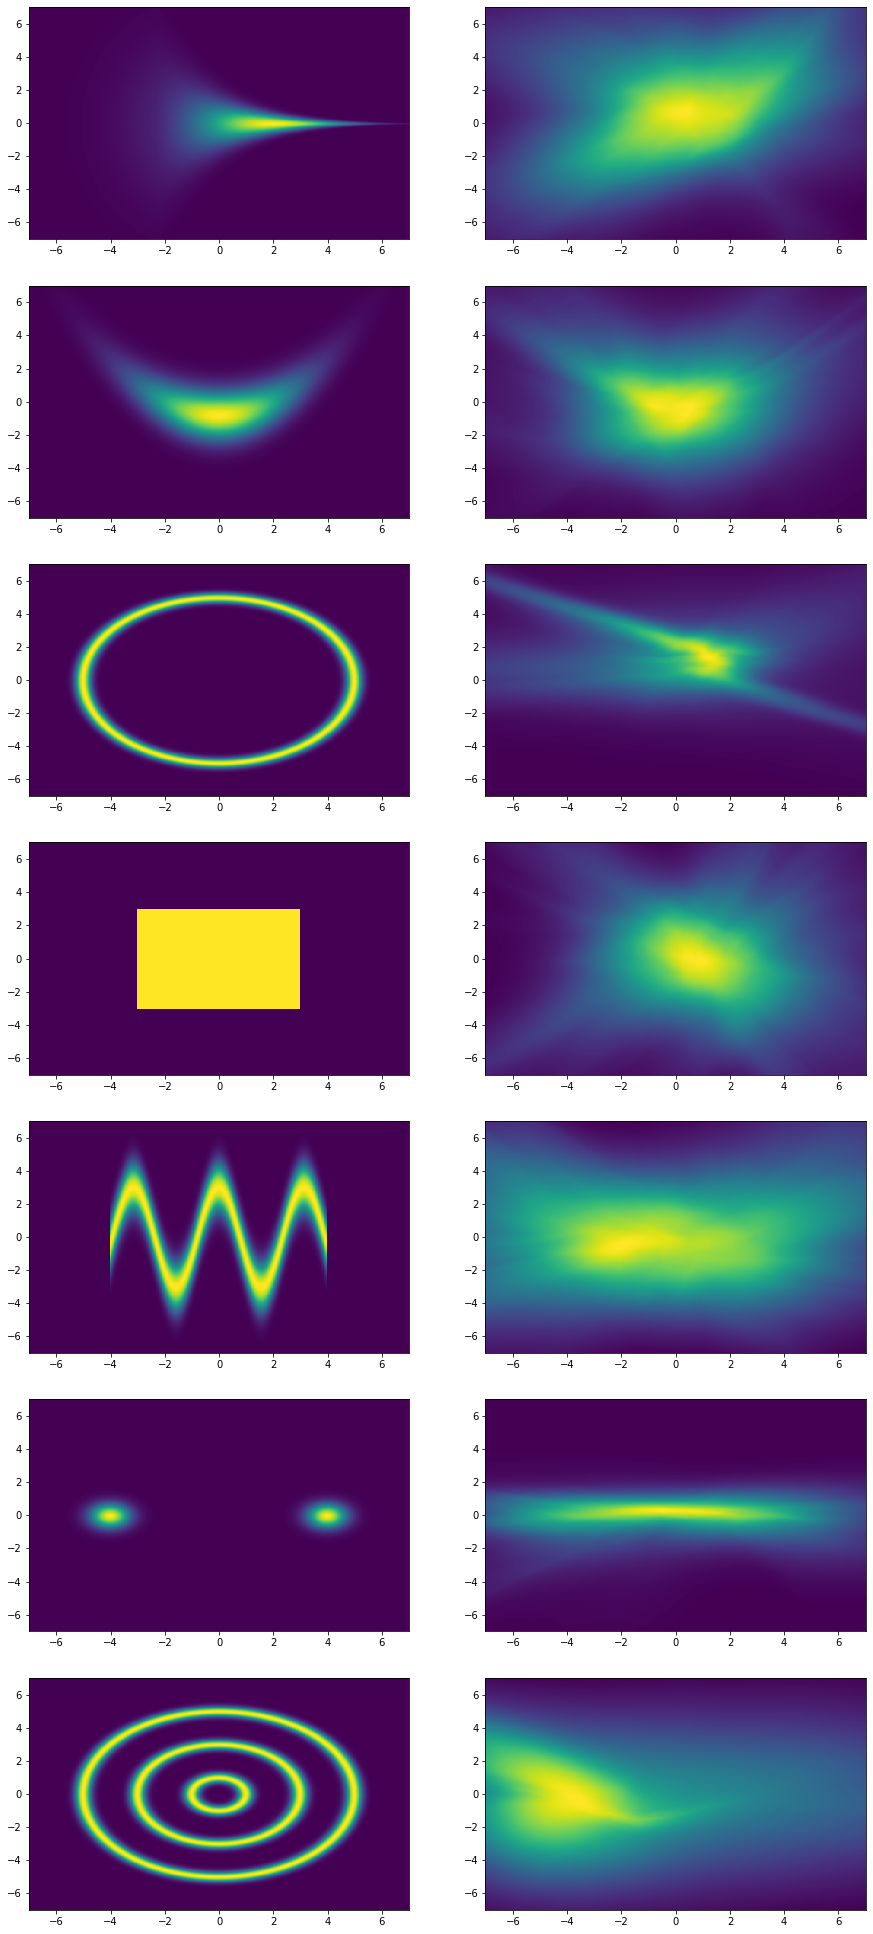

In [4]:
from utils import make_grid_data

x_interval, y_interval = np.linspace(-7, 7, 500), np.linspace(-7, 7, 500)


grid_x, grid_y, X = make_grid_data(x_interval, y_interval)
X = torch.from_numpy(X).float()

n = 10

plt.figure(figsize=(15,35))
for i in range(len(names)):
    name = names[i]
    obj = objs[i]
    flow = flows[i]
    
    print(name)
    
    pX_all = np.zeros((n, 500, 500))
    for j in range(n):
        flow.sample_params()

        log_pX = flow.log_likelihood(X)
        pX = torch.exp(log_pX)
        pX[~pX.isfinite()] = 0. # Make -inf of nan values to have 0 density
        pX = pX.numpy().reshape(len(x_interval), len(y_interval))

        pX_all[j, :, :] = pX
    
    
    plt.subplot(7, 2, 2*i+1)
    plot_object2D(obj, x_interval, y_interval)
    plt.subplot(7, 2, 2*i+2)
    plt.pcolormesh(grid_x, grid_y, pX_all.mean(axis=0), shading='auto')